In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,IPython, librosa, mir_eval
from os import listdir
from os.path import isfile, join,isdir
from IPython.display import Audio
from librosa.display import waveplot,specshow
from librosa.onset import onset_strength, onset_detect
from librosa.feature import melspectrogram, mfcc
from librosa import load

from collections import defaultdict,OrderedDict
import sklearn
from sklearn.preprocessing import StandardScaler,LabelEncoder
import scipy
from pandas import HDFStore,DataFrame



# Song Extraction from fma_small

1. Find the song folder path relative to the current computer
2. Retrieve the different genre classifications
3. Identify each song via its full path to song using index, to guarantee one-to-one mapping 
4. Sort in alphabetical order

In [2]:
#retrieving path to the fma_small directory and the corresponding meta data
HOME_DIR = IPython.utils.path.get_home_dir()

temp = join(HOME_DIR, 'Documents')
path_to_small_fma = join(temp, 'fma_small')
json_file = join(path_to_small_fma,'fma_small.json')
#locate meta_dta
print(path_to_small_fma)
df = pd.read_json(json_file)
print(json_file)


/Users/chibmac/Documents/fma_small
/Users/chibmac/Documents/fma_small/fma_small.json


In [3]:
#only choose top genre as the label
df = df.loc[:,['top_genre']]

#ensure that the genre name matches file name in fma_small, 
#i.e Oldtime / Historian conflict issue
df['top_genre']=df['top_genre'].apply(lambda y: y.split(os.sep)[0].strip())
#locate each individual song by its full path
df['temp'] = path_to_small_fma
str_index = ["%.2d" % x for x in df.index]
complete_genre_list = df['top_genre'].unique()

#create full path to file and store as a single array
df['full_path_to_song'] = df.temp.map(str)+ "/"+ df['top_genre'].values+ "/"+ str_index+ ".mp3"
del df['temp']
#keep songs according to alphabetical order of songs 
df.sort_values(by = 'top_genre', inplace = True)
df.head()


top_genre                                  full_path_to_song
100538  Electronic  /Users/chibmac/Documents/fma_small/Electronic/...
43206   Electronic  /Users/chibmac/Documents/fma_small/Electronic/...
43199   Electronic  /Users/chibmac/Documents/fma_small/Electronic/...
43153   Electronic  /Users/chibmac/Documents/fma_small/Electronic/...
43124   Electronic  /Users/chibmac/Documents/fma_small/Electronic/...

In [4]:
complete_genre_list_df = pd.DataFrame(complete_genre_list, columns = ['Genre'])

In [6]:
#retrieve number of songs per genre
genre_and_count = df['top_genre'].value_counts().sort_index()
all_songs_path = df['full_path_to_song'].values  
print(genre_and_count)

Electronic    400
Folk          400
Hip-Hop       400
Indie-Rock    400
Jazz          400
Old-Time      400
Pop           400
Psych-Rock    400
Punk          400
Rock          400
Name: top_genre, dtype: int64


In [7]:
song_counts = [] 
ordered_genres = [] 
full_song_df = OrderedDict()
genre_to_song_dict = {}


#retrieve number of songs per genre with the order preserved in two lists
#ordered_genres
#song_counts
for i,genre in enumerate(genre_and_count.index):
    ordered_genres.append(genre)
    temp = df['top_genre'].value_counts()[genre]
    song_counts.append(temp)

genre_to_song_zipped = zip(ordered_genres,song_counts)

num_of_genre = np.shape(genre_and_count)[0]
print("The number of genres is:", num_of_genre)

#dictionary with each song count and its corresponding genre
for genre,song_count in genre_to_song_zipped:
    genre_to_song_dict[genre] = song_count

genre_to_song_dict

The number of genres is: 10


{'Electronic': 400,
 'Folk': 400,
 'Hip-Hop': 400,
 'Indie-Rock': 400,
 'Jazz': 400,
 'Old-Time': 400,
 'Pop': 400,
 'Psych-Rock': 400,
 'Punk': 400,
 'Rock': 400}

In [8]:
num_of_genre = np.shape(genre_and_count)[0]
all_songs_path = df['full_path_to_song'].values

paths_dict = OrderedDict()

#prepend zero so we have a start point for all_songs_path 
#and avoid messing with indices

#use the cumulative sum to find none uniform ranges
song_counts.insert(0,0)
cumulative_sum = np.cumsum(song_counts,dtype=int)

#creates a dictionary of the genres and its corresponding path
for i,genre in enumerate(ordered_genres):
    str1=genre
    str2 = "_paths"
    genre_paths = "".join((str1,str2))
    paths_dict[genre_paths] = all_songs_path[cumulative_sum[i]:cumulative_sum[i+1]]

#paths_dict
#{genre_path_name: genre_paths}
print("{'Electronic_paths:[array_of_all_electronic_paths]}")

{'Electronic_paths:[array_of_all_electronic_paths]}


In [9]:
%%time
num_of_songs = 3
sampling_rate = 44100

genre_signals_dict = OrderedDict()
#creates a dictionary of the signals in a genre and their raw file
for genre_path_name,genre_paths in paths_dict.items():
    str1=genre_path_name[:-5]
    str2 = "signals"
    genre_signals = "".join((str1,str2))       
    try:
        first_three = genre_paths[:num_of_songs]
        genre_signals_dict[genre_signals] = [
        load(p,sr=None)[0] for p in first_three]
    except IOError as exc:
        print("Unable to locate folder")
        #raise IOError("%s: %s" % (genre_paths, exc.strerror))
        
#genre_signals_dict
#{genre_signals_name:genre_signals_paths}
print("{'Electronic_signals:[array_of_all_electronic_paths]}")

{'Electronic_signals:[array_of_all_electronic_paths]}
CPU times: user 5.13 s, sys: 424 ms, total: 5.56 s
Wall time: 5.56 s


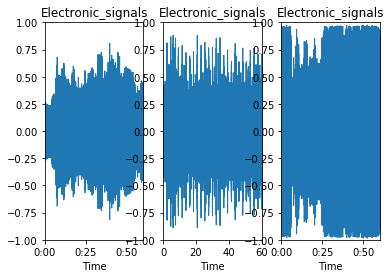

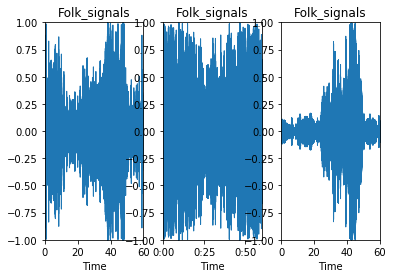

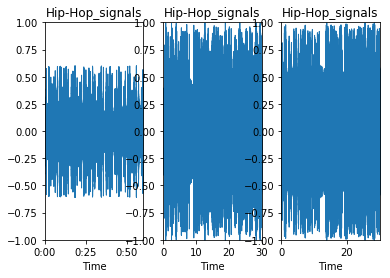

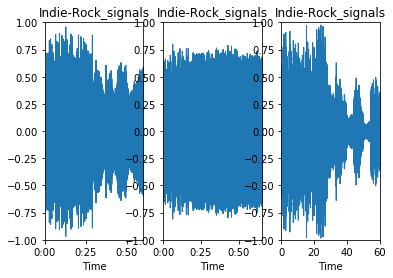

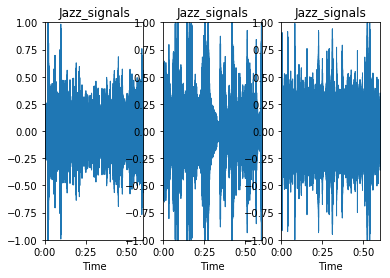

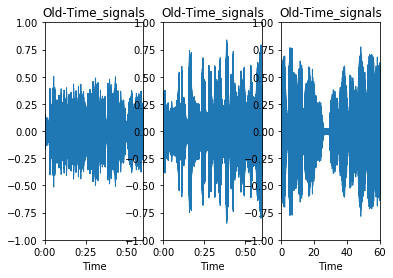

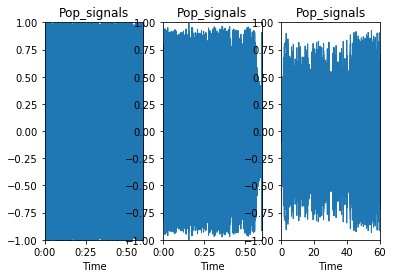

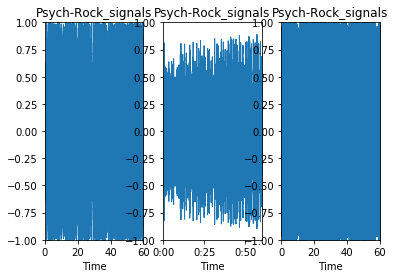

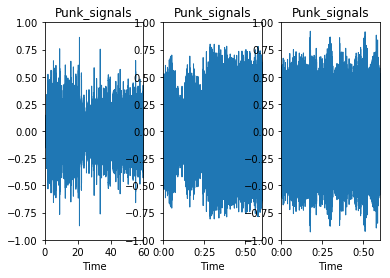

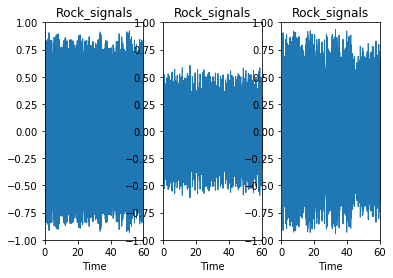

In [10]:
#plot the time series for each song according to the genres

#sig_lengths = []
for genre_signal_name,genre_signals in genre_signals_dict.items(): 
    for i, sig_amp in enumerate(genre_signals):
        plt.subplot(1, num_of_songs, i+1)
#        sig_lengths.append(len(sig_amp))
        waveplot(sig_amp)
        plt.ylim(-1, 1)
        plt.title(genre_signal_name)
    plt.figure()
        
    

# Basic Work Flow

## Segmentation - > Feature Extraction -> Classification


1. Segmentation:
2. Feature Extraction:
3. Machine learning:

https://ccrma.stanford.edu/wiki/MIR_workshop_2014

# Retrieve Audio

1. Time Domain Representation (Wave plot)
2. Frequency Domain Representation (Spectogram)

In [11]:
song_path = path_to_small_fma + "/Hip-Hop/5.mp3"
song_path1 = path_to_small_fma + "/Electronic/100538.mp3"
song_path2 = path_to_small_fma + "/Pop/10396.mp3"

song_amp  = librosa.load(song_path, sr = None)[0]
song_amp1  = librosa.load(song_path1, sr=None)[0]
song_amp2  = librosa.load(song_path2, sr=None)[0]

demo_songs =[song_amp,song_amp1,song_amp2]


# Play it back!
Audio(data=song_amp, rate=sampling_rate)

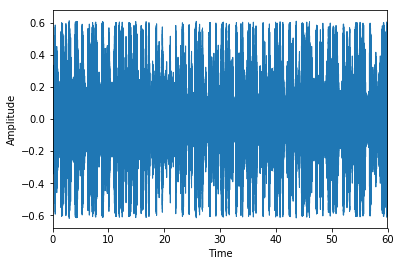

In [12]:
waveplot(demo_songs[0])
plt.ylabel('Amplitude')

#### The zero crossing rate is the number of times the signal changes sign in a given period of time (usually one second).

#### The zero crossing detector looks at the second derivative computed in discrete form calclate changes 

[0.059344571161798053]

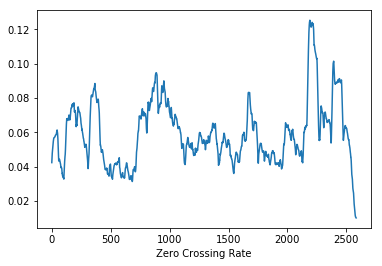

In [13]:
from librosa.feature import (zero_crossing_rate,spectral_centroid,
spectral_bandwidth)
from librosa import logamplitude


man_features_list = []
zcr = zero_crossing_rate(demo_songs[0],sampling_rate)
plt.plot(zcr[0])
plt.xlabel('Zero Crossing Rate')
avg_zcr = np.mean(zcr)
man_features_list.append(avg_zcr)
man_features_list

# Spectral features

moments in stats i.e mean and variance, here we have anothers such as spectral centroid, bandwidth, skewness, kurtosis


Spectral features are often used to analyse harmony or timbre. Usually the product of a spectogram and a filter bank

## Pitch vs Pitch class
Chroma measures the amount of energy in each pitch class,
frame1, frame2,frame3 and collaspe down (many-to-one mapping) expectation 
of pitch class''

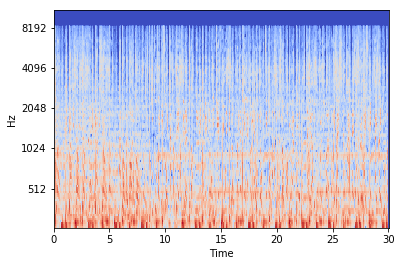

In [14]:
S = librosa.feature.melspectrogram(demo_songs[0], sr=sampling_rate, n_fft=1024)
logS = librosa.logamplitude(S)
specshow(logS, sr=sampling_rate, x_axis='time', y_axis='mel')


# Constant-Q-transform

#### constant q transform is for a direct log-frequency analysis in addition, one vertical move represents one semi-tone, so things are shit invariant vertically aswell as horizontally

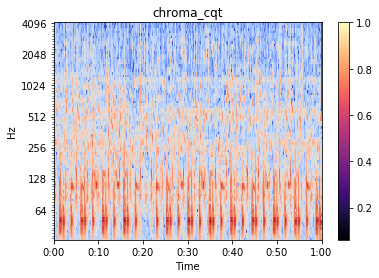

In [15]:
cqt = librosa.cqt(demo_songs[0],sampling_rate)
chroma_cqt = librosa.feature.chroma_cqt(y = demo_songs[0],sr = sampling_rate)

specshow(chroma_cqt)
plt.title('chroma_cqt')
plt.colorbar()

specshow(librosa.logamplitude(cqt**2), x_axis = 'time', y_axis = 'cqt_hz')

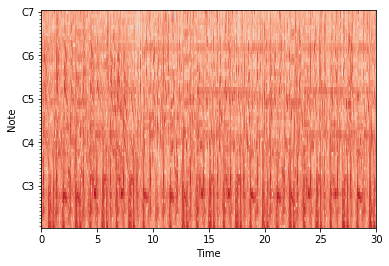

In [16]:
fmin = librosa.midi_to_hz(36)
C = librosa.cqt(demo_songs[0], sr=sampling_rate, fmin=fmin, n_bins=60)
logC = librosa.logamplitude(C)
specshow(logC, sr=sampling_rate, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')

In [17]:
def extract_features(signal,sampling_rate,n_mfcc,genre):

    zcr = zero_crossing_rate(signal)[0]
    norm_zcr = StandardScaler().fit_transform(zcr.reshape(1,-1))
    avg_zcr = np.mean(zcr)
    std_zcr = np.std(zcr)
    
    act_mfcc = mfcc(signal, sr=sampling_rate, n_mfcc=n_mfcc)
    norm_mfcc = StandardScaler().fit_transform(act_mfcc)
    avg_mfcc = np.mean(act_mfcc)
    std_mfcc = np.std(act_mfcc)
    
    return [
        avg_zcr,std_zcr,avg_mfcc,std_mfcc,genre
    ]

In [18]:
n_mfcc = 12
d={}
#'Average_tonnetz','Std_tonnetz'

for i in range(len(demo_songs)):
    song_num = str(i)
    if i ==0:
        genre = "Hip-Hop"
    elif i==1:
        genre = "Electronic"
    else:
        genre = "Pop"
        
    d[song_num] = extract_features(demo_songs[i],sampling_rate,n_mfcc,genre)


index = ['Average_zcr','Std_zcr','Average_mfcc','Std_mfcc','Encoded_Genre']

In [19]:
demo_df = pd.DataFrame(data=d,index =index)
demo_df = demo_df.T
demo_df

Average_zcr    Std_zcr Average_mfcc Std_mfcc Encoded_Genre
0   0.0597842    0.04814      1.30054  66.3195       Hip-Hop
1   0.0328551  0.0182481      3.23027  74.6956    Electronic
2   0.0521829   0.020888      7.22644  65.9183           Pop

In [21]:
song_num = 0
tot_num_of_songs = cumulative_sum[-1]
indiv_song_path= []
for genre_path_name,genre_paths in paths_dict.items(): 
    song_num=song_num+1
    indiv_song_path.append(genre_paths)

    
indiv_song_path_list = np.array(indiv_song_path).reshape(tot_num_of_songs,)

In [22]:
indiv_song_path_list


array(['/Users/chibmac/Documents/fma_small/Electronic/100538.mp3',
       '/Users/chibmac/Documents/fma_small/Electronic/43206.mp3',
       '/Users/chibmac/Documents/fma_small/Electronic/43199.mp3', ...,
       '/Users/chibmac/Documents/fma_small/Rock/693.mp3',
       '/Users/chibmac/Documents/fma_small/Rock/41813.mp3',
       '/Users/chibmac/Documents/fma_small/Rock/9999.mp3'], dtype=object)

In [23]:
genres = []
for song_num in range(len(indiv_song_path_list)):
    temp = indiv_song_path_list[song_num].split(os.sep)[-2]
    genres.append(temp)
        

In [24]:
le = LabelEncoder()
encoded_genres= le.fit(genres)
encoded_genres

#Label Encoding Mapping
encoder_df= pd.DataFrame(data= {'Genre':genres,
                   'Encoded_Genre':le.transform(genres)})
encoder_df.head()

Encoded_Genre       Genre
0              0  Electronic
1              0  Electronic
2              0  Electronic
3              0  Electronic
4              0  Electronic

In [25]:
print("I AM HERE")

I AM HERE


In [26]:
%%time

tot_num_of_songs = cumulative_sum[-1]
final_d = np.zeros((tot_num_of_songs,5))
print(final_d.shape)

for song_num in range(len(indiv_song_path_list)):
    try:
        indiv_song_path = indiv_song_path_list[song_num]
        song_signal = librosa.load(indiv_song_path,sr=None)[0]
        curr_song_genre = encoder_df['Encoded_Genre'][song_num]
        final_d[song_num]= extract_features(song_signal,sampling_rate,n_mfcc,curr_song_genre)
    except IOError as exc:
        print("Unable to locate folder")
    


            

(4000, 5)
Unable to locate folder
CPU times: user 2h 5min 22s, sys: 11min 9s, total: 2h 16min 31s
Wall time: 36min 57s


In [27]:
print("I AM HERE")

I AM HERE


In [35]:

complete_df = pd.DataFrame(data=final_d.T,index =index)
complete_df = complete_df.T

complete_df.head()

Average_zcr   Std_zcr  Average_mfcc   Std_mfcc  Encoded_Genre
0     0.032855  0.018248      3.230270  74.695595            0.0
1     0.079066  0.041909      3.799809  56.969163            0.0
2     0.056989  0.045686      5.151233  47.566412            0.0
3     0.039981  0.032235      8.900865  60.214362            0.0
4     0.072730  0.039213      7.148043  50.758430            0.0

In [40]:
complete_df.shape

(4000, 5)

In [41]:
encoder_df

Encoded_Genre       Genre
0                 0  Electronic
1                 0  Electronic
2                 0  Electronic
3                 0  Electronic
4                 0  Electronic
5                 0  Electronic
6                 0  Electronic
7                 0  Electronic
8                 0  Electronic
9                 0  Electronic
10                0  Electronic
11                0  Electronic
12                0  Electronic
13                0  Electronic
14                0  Electronic
15                0  Electronic
16                0  Electronic
17                0  Electronic
18                0  Electronic
19                0  Electronic
20                0  Electronic
21                0  Electronic
22                0  Electronic
23                0  Electronic
24                0  Electronic
25                0  Electronic
26                0  Electronic
27                0  Electronic
28                0  Electronic
29                0  Electronic
...             ...         ...
3970              9        Rock
3971              9        Rock
3972              9        Rock
3973              9        Rock
3974              9        Rock
3975              9        Rock
3976              9        Rock
3977              9        Rock
3978              9        Rock
3979              9        Rock
3980              9        Rock
3981              9        Rock
3982              9        Rock
3983              9        Rock
3984              9        Rock
3985              9        Rock
3986              9        Rock
3987              9        Rock
3988              9        Rock
3989              9        Rock
3990              9        Rock
3991              9        Rock
3992              9        Rock
3993              9        Rock
3994              9        Rock
3995              9        Rock
3996              9        Rock
3997              9        Rock
3998              9        Rock
3999              9        Rock

[4000 rows x 2 columns]

In [56]:
final_df = pd.concat([complete_df,encoder_df],axis =1)

final_df = final_df.iloc[:,[0,1,2,3,4,6]]
final_df

Average_zcr   Std_zcr  Average_mfcc    Std_mfcc  Encoded_Genre  \
0        0.032855  0.018248      3.230270   74.695595            0.0   
1        0.079066  0.041909      3.799809   56.969163            0.0   
2        0.056989  0.045686      5.151233   47.566412            0.0   
3        0.039981  0.032235      8.900865   60.214362            0.0   
4        0.072730  0.039213      7.148043   50.758430            0.0   
5        0.094670  0.063569     10.814433   34.375438            0.0   
6        0.080279  0.052155      7.654402   45.443274            0.0   
7        0.045492  0.026759     -7.790051   81.313067            0.0   
8        0.070773  0.082080     -7.135674   96.317405            0.0   
9        0.036450  0.027679      7.800353   61.836690            0.0   
10       0.023234  0.016330     13.648432   44.375243            0.0   
11       0.246903  0.109789      8.321994   23.791940            0.0   
12       0.042469  0.051867      1.033551   92.915230            0.0   
13       0.020512  0.027547      5.976698   96.893624            0.0   
14       0.035157  0.016827    -11.003607  100.808043            0.0   
15       0.045196  0.063991      5.282895   78.805461            0.0   
16       0.058808  0.040653      9.802280   62.566408            0.0   
17       0.027118  0.014466      5.428195   75.378614            0.0   
18       0.087877  0.022734      6.438868   53.468025            0.0   
19       0.031420  0.011908      1.964822   67.601279            0.0   
20       0.051786  0.052117     -6.455740   88.376178            0.0   
21       0.064838  0.043177      9.235535   59.455723            0.0   
22       0.047313  0.032341      1.476611   68.473090            0.0   
23       0.035429  0.035141      8.755263   52.897437            0.0   
24       0.049286  0.070238      7.776040   65.283788            0.0   
25       0.053745  0.045962      1.913334   65.595422            0.0   
26       0.030715  0.005754     -4.459333   89.457853            0.0   
27       0.069942  0.019327     -9.555069   95.477140            0.0   
28       0.015966  0.005700      5.900989   90.480192            0.0   
29       0.018021  0.007089      0.706097   86.800942            0.0   
...           ...       ...           ...         ...            ...   
3970     0.073897  0.028106     -4.125356   82.042062            9.0   
3971     0.061058  0.019480      2.017652   69.490892            9.0   
3972     0.046540  0.017668     -1.956401   85.609841            9.0   
3973     0.103925  0.024139      9.859056   50.569139            9.0   
3974     0.085671  0.032545     11.780280   46.638149            9.0   
3975     0.080815  0.018836      2.471857   61.540809            9.0   
3976     0.054218  0.035378      8.445052   68.168608            9.0   
3977     0.057267  0.015252      6.622582   67.888613            9.0   
3978     0.078543  0.037503     12.419272   45.568965            9.0   
3979     0.085443  0.029901     10.733216   46.620936            9.0   
3980     0.077016  0.025721     12.964299   42.957023            9.0   
3981     0.058748  0.034198     10.960036   56.202363            9.0   
3982     0.055462  0.071764     -8.940933   93.414839            9.0   
3983     0.048389  0.031747      6.820852   57.930389            9.0   
3984     0.048729  0.025861     -5.319750   98.015938            9.0   
3985     0.057907  0.020626    -12.433349   94.769310            9.0   
3986     0.087918  0.022886     -4.693690   64.051361            9.0   
3987     0.040065  0.018197     -6.544094  111.070383            9.0   
3988     0.024934  0.009204     -4.228839  110.018466            9.0   
3989     0.029082  0.009039      8.324259   68.329868            9.0   
3990     0.029017  0.010124      8.578326   69.611994            9.0   
3991     0.069324  0.030180      2.797896   60.501828            9.0   
3992     0.044970  0.021923      0.013696   81.405992            9.0   
3993     0.084087  0.029361      7.702080   46

In [57]:
final_df.to_csv("finalDF.csv",sep=',')